In [1]:
#Imports
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# own utils
from utils.graph_utils import *


# Data


- provide data in the form of a pandas dataframe, if there are iamges add the paths to each image to the df

In [2]:
DATA_PATH = "/home/bule/TramDag/data"
WEIGHTS_DIR="/home/bule/TramDag/weights"

### Example 1 SoCal , California House Prices

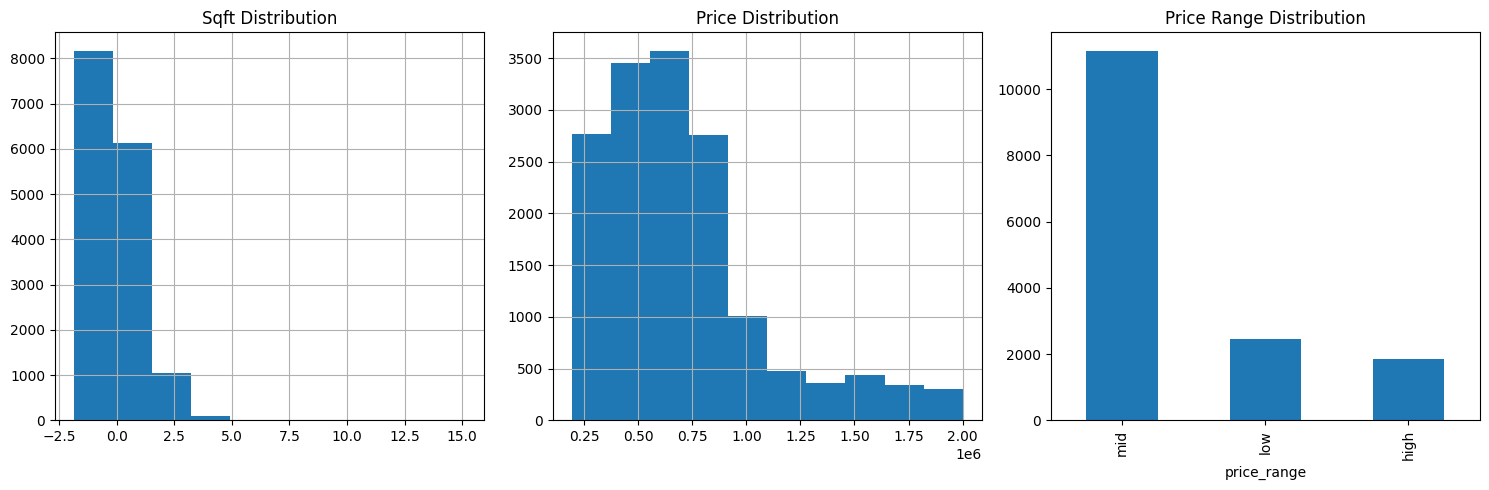

,image_id,street,citi,n_citi,bed,bath,sqft,price,sqft_scaled,images,price_range,price_range_int
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900,-0.598761,/home/bule/TramDag/data/socal2/socal_pics/1183...,low,0
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500,-1.424855,/home/bule/TramDag/data/socal2/socal_pics/68.jpg,low,0
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950,-1.340002,/home/bule/TramDag/data/socal2/socal_pics/7463...,low,0
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000,-1.064963,/home/bule/TramDag/data/socal2/socal_pics/2530...,low,0
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100,0.363878,/home/bule/TramDag/data/socal2/socal_pics/2001...,mid,1


In [ ]:
# toy example  https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal

# import kagglehub
# kagglehub.dataset_download("ted8080/house-prices-and-images-socal", path=DATA_PATH)




# TODO make sure to not scale the data for training the models

# X0 sqrft continous
# X1 Images
# X2 Price in ranges low, mid , high 
houses_df=pd.read_csv(os.path.join(DATA_PATH ,"socal2.csv"))


### X0 -> squarfoot continous

# Instantiate scaler
scaler = StandardScaler()
houses_df['sqft_scaled'] = scaler.fit_transform(houses_df[['sqft']])

### X1 -> images -> path to images
image_paths=[os.path.join(DATA_PATH,"socal2/socal_pics",pth) for pth in os.listdir(os.path.join(DATA_PATH, "socal2/socal_pics"))]
houses_df['images']=image_paths

### X2 prices -> ordinal -> low, mid, high -> map to 0,1,2
houses_df['price_range'] = pd.cut(
    houses_df['price'], 
    bins=[0, 350_000, 1_100_000, float('inf')],  # Adjust bin edges
    labels=['low', 'mid', 'high'],  
    include_lowest=True  # Ensures 0 is included in 'low'
)
houses_df['price_range_int'] = houses_df['price_range'].map({'low': 0, 'mid': 1, 'high': 2})  # Encode labels


# plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
houses_df['sqft_scaled'].hist(ax=axes[0])



axes[0].set_title('Sqft Distribution')




houses_df['price'].hist(ax=axes[1])
axes[1].set_title('Price Distribution')
houses_df['price_range'].value_counts().plot(kind='bar', ax=axes[2])
axes[2].set_title('Price Range Distribution')
plt.tight_layout()
plt.show()
houses_df.head(5)

### train test split

In [4]:
# train
train_df, temp_df = train_test_split(houses_df, test_size=0.2, stratify=houses_df['price_range_int'], random_state=42)
# Validation and test
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['price_range_int'], random_state=42)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 12379, Validation size: 1547, Test size: 1548


# Define graph Structure

- define graph and which shift and intercept terms to use


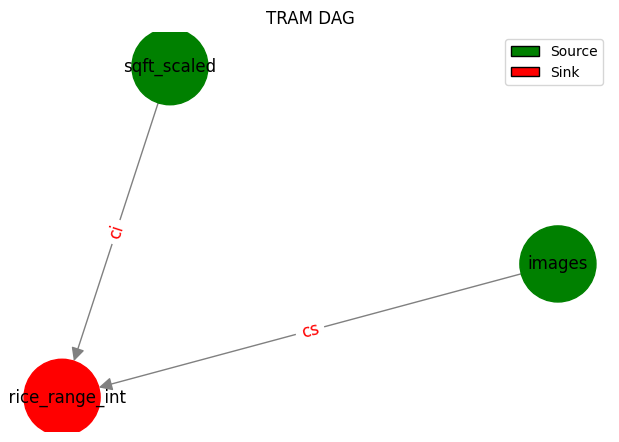

In [5]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 

# TODO support for interactions in CI model eg CI_1

# Example 1  Socal, sqft images price_range   3x3: 
# data_type={'X0':'cont','X1':'other','X2':'ord'}  # continous , images , ordinal
data_type={'sqft_scaled':'cont','images':'other','price_range_int':'ord'}  # continous , images , ordinal
adj_matrix = np.array([
    [ "0", "0", "ci"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "cs"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)


# # example 2 4x4
# data_type={'X0':'other','X1':'ord','X2':'ord','X3':'ord'}  # images, continous, continous, continous    
# adj_matrix = np.array([
#                                 ["0", "ci", "ls", "ci"],  # A -> B (cs), A -> C (ls)
#                                 ["0", "0", "0", "ls"],  # B -> D (ls)
#                                 ["0", "0", "0", "cs"],  # C -> D (cs)
#                                 ["0", "0", "0", "0"]    # No outgoing edges from D
#                             ], dtype=object)


plot_dag(adj_matrix,data_type, seed=42)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


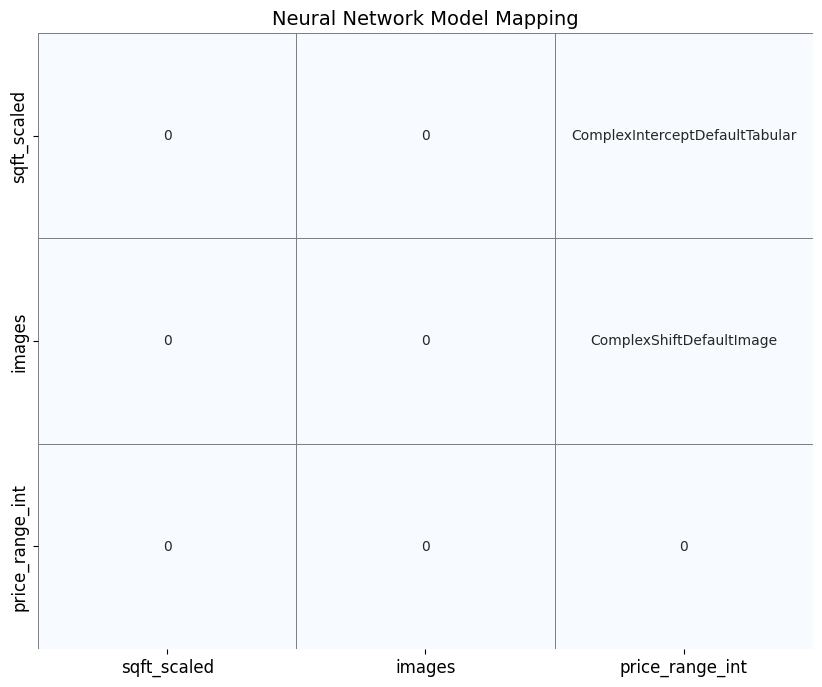

In [6]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix,data_type)

- add custom models for the ci or cs

In [7]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [8]:
#TODO : OPTION write config to a argparser to  and args object to pass datatypes


conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
conf_dict

{'sqft_scaled': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'images': {'Modelnr': 1,
  'data_type': 'other',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'price_range_int': {'Modelnr': 2,
  'data_type': 'ord',
  'node_type': 'sink',
  'parents': ['sqft_scaled', 'images'],
  'parents_datatype': ['cont', 'other'],
  'transformation_terms_in_h()': {'sqft_scaled': 'ci', 'images': 'cs'},
  'transformation_term_nn_models_in_h()': {'sqft_scaled': 'ComplexInterceptDefaultTabular',
   'images': 'ComplexShiftDefaultImage'}}}

## Fit models

- each model independently fitting

In [9]:
from utils.ontram_models import *
from utils.ontram_model_utils import *

from utils.ontram_data import *
from torchvision import transforms
from utils.loss_ordinal import *

DEV_TRAINING=True

In [10]:
batch_size=512


if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")





for node in conf_dict:
    print(f'\n----------node: {node}--------')
    
    # skip source nodes with images since they are not supported yet
    if (conf_dict[node]['node_type'] == 'source') and (conf_dict[node]['node_type'] == 'other'):
        continue
    
    
    # TODO add args to the models via config file eg nn_int = globals()[nn_int_name](args) , args from conf
    
    
    #*************
    # aligning with code from lisa the ontram model takes a nn_int and a list of nn_shifts
    # -> nn_int is the intercept term
    # -> nn_shifts is a list of models that are used for the shift terms
    # if there are no shift terms, nn_shifts is None
    #**********
    
    #load tram_model per node
    
    ######################################################## 1. Create tram Model ######################
    
    tram_model = get_fully_specified_tram_model(node,conf_dict,verbose=True)
    # TODO test modelloading for possible model combinations 
    
    ##################################################### 2. Create Dataloaders ######################
    
    train_loader, val_loader = get_dataloader(node, conf_dict, train_df, val_df, batch_size=32,verbose=True)
    # TODO Test laoders for different datasets
    
    ##################################################### 3. Train Model ######################
    
    
    
    
    
    # TODO add args to the training via config file
    optimizer=None
    use_scheduler=True

    # Hyperparameters
    epochs = 10
    
    
    # TODO implement for continous -> change loss funciton 
    # TODO ordinal inputs? 
    
    
    
    

    best_val_loss = float('inf')
    train_loss_hist = []
    val_loss_hist = []
            
            
            
    if optimizer is None:
        optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.001, eps=1e-7, weight_decay=0.0)
    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    
    if DEV_TRAINING:
    
        for epoch in range(epochs):
            train_loss = 0.0
            tram_model.to(device)
            tram_model.train()






            for x, y in train_loader:
                
                
                if conf_dict[node]['node_type'] == 'source':
                    
                    print(f'x[0]: {x[0].shape}')
                    x[0] = x[0].unsqueeze(1).to(device)  # intercept input should be  all ones for node
                    print(f'x[0]: {x[0].shape}')
                    
                    
                    
                    ## only for ordinal node!
                    y = y.to(device).long()
                    y = F.one_hot(y, num_classes=3).float()

                    optimizer.zero_grad()
                    y_pred = tram_model(int_input=x[0])
                    loss = ontram_nll(y_pred, y)

                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    #TODO make sure that sources just get 1s in the input to learn h
                    
                    
                
                
                
                
                else:
                    # Move inputs to device
                    x[0] = x[0].unsqueeze(1).to(device)  # intercept input
                    x[1:] = [xi.to(device) for xi in x[1:]]  # shifts inputs

                    
                print(f'x[0]: {x[0].shape}, x[1]: {x[1].shape}, y: {y.shape}')
                
                
                
                ## only for ordinal node!
                y = y.to(device).long()
                y = F.one_hot(y, num_classes=3).float()

                optimizer.zero_grad()
                y_pred = tram_model(int_input=x[0], shift_input=x[1:])
                loss = ontram_nll(y_pred, y)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            train_loss_hist.append(avg_train_loss)

            # Validation phase
            val_loss = 0.0
            tram_model.eval()
            with torch.no_grad():
                for x, y in val_loader:
                    x[0] = x[0].unsqueeze(1).to(device)
                    x[1:] = [xi.to(device) for xi in x[1:]]
                    y = y.to(device).long()
                    y = F.one_hot(y, num_classes=3).float()

                    y_pred = tram_model(int_input=x[0], shift_input=x[1:])
                    loss = ontram_nll(y_pred, y)

                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            val_loss_hist.append(avg_val_loss)

            # Print epoch results
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save best model
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(tram_model.state_dict(), os.path.join(WEIGHTS_DIR,"best_model.pt"))
                print("Saved new best model.")


Train with GPU support.

----------node: sqft_scaled--------
>>>>>>>>>>>>  source node --> only  modelled only  by si
TramModel(
  (nn_int): SimpleIntercept(
    (fc): Linear(in_features=1, out_features=20, bias=False)
  )
)
>>>>>>>>>>>>  source node --> x in dataloader contains just 1s 
x[0]: torch.Size([32])
x[0]: torch.Size([32, 1])


/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [3,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [5,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [8,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [15,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKernel.cu:365: operator(): block: [0,0,0], thread: [18,0,0] Assertion `idx_dim >= 0 && idx_dim < index_size && "index out of bounds"` failed.
/pytorch/aten/src/ATen/native/cuda/ScatterGatherKerne

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

In [ ]:
tram_model

# last model target ordinal

In [ ]:
optimizer=None
use_scheduler=True

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Train with GPU support.")
else:
    device = torch.device('cpu')
    print("No GPU found, train with CPU support.")
    
if optimizer is None:
    optimizer = torch.optim.Adam(tram_model.parameters(), lr=0.001, eps=1e-7, weight_decay=0.0)
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)
    

In [ ]:
from utils.loss_ordinal import *

In [ ]:
# TODO check outputs of dataloader  onehot? cont? d type

In [ ]:

epochs=30
# Set device



# Training loop
for epoch in range(epochs):
    train_loss = 0.0
    tram_model.to(device)
    tram_model.train()

    for x, y in train_loader:
        # Move inputs to device
        x[0] = x[0].unsqueeze(1).to(device)  # Tabular input
        x[1:] = [xi.to(device) for xi in x[1:]]  # Image inputs

        y = y.to(device).long()
        y = F.one_hot(y, num_classes=3).float()

        optimizer.zero_grad()
        y_pred = tram_model(int_input=x[0], shift_input=x[1:])
        loss = ontram_nll(y_pred, y)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_hist.append(avg_train_loss)

    # Validation phase
    val_loss = 0.0
    tram_model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x[0] = x[0].unsqueeze(1).to(device)
            x[1:] = [xi.to(device) for xi in x[1:]]
            y = y.to(device).long()
            y = F.one_hot(y, num_classes=3).float()

            y_pred = tram_model(int_input=x[0], shift_input=x[1:])
            loss = ontram_nll(y_pred, y)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_hist.append(avg_val_loss)

    # Print epoch results
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(tram_model.state_dict(), os.path.join(WEIGHTS_DIR,"best_model.pt"))
        print("Saved new best model.")

# Plotting loss history
plt.figure(figsize=(10, 5))
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()